## META-ANALYSIS: Applying a Random Effects Model with inverse variance weighting 

##### summary of the steps undertaken:
    1. Import data (previously generated Hedges' G values and Variances (Vg values))
    2. Calculate Combined (Mean) Effect size (M*) for each MGI gene symbol
    3. Calculate Z-scores and p values for each gene symbol

  es = effect sizes, imported from indexed file (Hedges g)
  
  W = weight  (inverse of Variance in Hedges g)
  $$ \frac{1}{var}$$
  
  M* = Combined (mean) effect size
  
  W* = weighting in random effects model (inverse of study variance + between studies variance)
   $$ \frac{1}{var + Tau^2} $$
  

With

$$  {Tau^2\ } = \frac{Q - df}{C}  $$  

Where:

$${ Q\ }= \sum{es^2*W} - \frac{(\sum{es*W})^2}{\sum{W}} $$


$$ C= \sum{W} -\frac{\sum{W^2}}{\sum{W}} $$ 

and I squared statistic (heterogeneity within the meta-analysis, see Higgins et al 2003 BMJ, 327:557-60)
$$  {I^2\ } = \frac{Q^2 - df}{Q}  $$  

## set up 

In [1]:
import pandas as pd # Dataframes and File IO
import numpy as np # numerical calculations
import matplotlib.pyplot as plt # Plotting
import scipy.stats as st # statistical package (p_vals)
%matplotlib inline

In [2]:
df=pd.read_csv('input_files/Symbol_forMeta.csv', index_col=0)# mport indexd values from studies in meta-analysis 
df.head()

,MoEx_Enrich,MoEx_Hedges_g,MoEx_Var_g,MoEx_SEg,MoGene_Enrich,MoGene_Hedges_g,MoGene_Var_g,MoGene_SEg,RNA_Seq_Enrich,RNA_Seq_Hedges_g,RNA_Seq_Var_g,RNA_Seq_SEg,430V2_Enrich,430V2_Hedges_g,430V2_Var_g,430V2_SEg,430AV2_Enrich,430AV2_Hedges_g,430AV2_Var_g,430AV2_SEg
0610005C13Rik,0.703463,1.705831,0.252462,0.502456,NaN,NaN,NaN,NaN,0.015697,0.569601,0.230165,0.479756,-0.065548,-0.308451,0.373230,0.610925,0.071840,0.392799,0.399175,0.631803
0610007P14Rik,-0.329912,-1.349822,0.233036,0.482738,-0.370831,-0.995738,0.176630,0.420274,-0.003165,-0.015585,0.220630,0.469713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0610008F07Rik,0.284077,0.610090,0.207147,0.455134,-0.136057,-0.463423,0.160449,0.400560,NaN,NaN,NaN,NaN,-0.029420,-0.177580,0.371242,0.609296,-0.034139,-0.240750,0.394796,0.628328
0610009B14Rik,0.187861,1.120296,0.222912,0.472136,-0.252100,-1.107915,0.181547,0.426083,-0.007089,-0.196339,0.221757,0.470910,-0.326035,-1.337117,0.426128,0.652785,NaN,NaN,NaN,NaN
0610009B22Rik,0.008482,0.020895,0.200508,0.447781,-0.141382,-0.267000,0.157460,0.396812,0.260870,0.744853,0.236941,0.486766,0.392765,1.473526,0.438109,0.661898,0.951853,5.058482,1.555264,1.247102


In [3]:
df['W1'] = 1/df['MoEx_Var_g'] # weight as 1/variance
df['W2'] = 1/df['MoGene_Var_g']
df['W3'] = 1/df['430V2_Var_g']
df['W4'] = 1/df['430AV2_Var_g']
df['W5'] = 1/df['RNA_Seq_Var_g']

In [4]:
df['W1^2'] = np.square(df['W1']) # squared weights
df['W2^2'] = np.square(df['W2'])
df['W3^2'] = np.square(df['W3'])
df['W4^2'] = np.square(df['W4'])
df['W5^2'] = np.square(df['W5'])

In [5]:
df['esSqW1'] = np.square(df['MoEx_Hedges_g'])*df['W1']
df['esSqW2'] = np.square(df['MoGene_Hedges_g'])*df['W2']
df['esSqW3'] = np.square(df['430V2_Hedges_g'])*df['W3']
df['esSqW4'] = np.square(df['430AV2_Hedges_g'])*df['W4']
df['esSqW5'] = np.square(df['RNA_Seq_Hedges_g'])*df['W5']


In [6]:
df['esW1'] = df['MoEx_Hedges_g']*df['W1']
df['esW2'] = df['MoGene_Hedges_g']*df['W2']
df['esW3'] = df['430V2_Hedges_g']*df['W3']
df['esW4'] =  df['430AV2_Hedges_g']*df['W4']
df['esW5'] = df['RNA_Seq_Hedges_g']*df['W5']


In [7]:
#df.head()

In [8]:
# for each row count degrees of freedom as 'Hedges_g' colums with data in, -1

df['df'] = df.iloc[:,[1,5,9,13,17]].count(axis=1)-1 

In [9]:
Qa = df.filter(regex='esSq').sum(axis=1)
Qb = np.square(df.filter(regex='esW').sum(axis=1))
Qc = df.filter(regex='^W\d$').sum(axis=1)  
Cd =  df.filter(regex='^W\d\^\d$').sum(axis=1)


In [10]:
df['Q'] = Qa -(Qb/Qc)
df['C'] = Qc -(Cd/Qc)

In [11]:
df['Tau^2'] = (df['Q']-df['df'])/df['C']
df['Tau^2'].where(df['Tau^2']>0, 0,inplace=True) # set Tau-squared to 0 where <0
df['Tau^2'].where(df['Tau^2']<100000, 0,inplace=True) # set Tau-squared to 0 where err or inf
df.head()

,MoEx_Enrich,MoEx_Hedges_g,MoEx_Var_g,MoEx_SEg,MoGene_Enrich,MoGene_Hedges_g,MoGene_Var_g,MoGene_SEg,RNA_Seq_Enrich,RNA_Seq_Hedges_g,...,esSqW5,esW1,esW2,esW3,esW4,esW5,df,Q,C,Tau^2
0610005C13Rik,0.703463,1.705831,0.252462,0.502456,NaN,NaN,NaN,NaN,0.015697,0.569601,...,1.409619,6.756779,NaN,-0.826437,0.984028,2.474747,3,7.042189,9.930513,0.407047
0610007P14Rik,-0.329912,-1.349822,0.233036,0.482738,-0.370831,-0.995738,0.176630,0.420274,-0.003165,-0.015585,...,0.001101,-5.792322,-5.637409,NaN,NaN,-0.070641,2,4.302481,9.582901,0.240270
0610008F07Rik,0.284077,0.610090,0.207147,0.455134,-0.136057,-0.463423,0.160449,0.400560,NaN,NaN,...,NaN,2.945202,-2.888300,-0.478341,-0.609810,NaN,3,3.301801,11.631238,0.025947
0610009B14Rik,0.187861,1.120296,0.222912,0.472136,-0.252100,-1.107915,0.181547,0.426083,-0.007089,-0.196339,...,0.173834,5.025728,-6.102643,-3.137831,NaN,-0.885379,3,15.217340,12.321941,0.991511
0610009B22Rik,0.008482,0.020895,0.200508,0.447781,-0.141382,-0.267000,0.157460,0.396812,0.260870,0.744853,...,2.341539,0.104210,-1.695672,3.363378,3.252492,3.143626,4,20.595754,13.688561,1.212381


In [12]:
df['I^2'] = (np.square(df['Q'])-df['df'])/df['Q']
df['I^2'].where(df['I^2']>0, 0,inplace=True)   # set I-squared to 0 where <0
df['I^2'].where(df['I^2']<100000, 0,inplace=True)  # set I-squared to 0 where err or inf

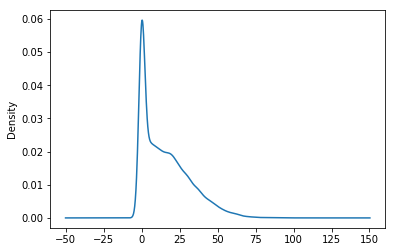

In [13]:
df['I^2'].plot(kind='kde')  # have a look at distribution of I-squared values

In [14]:
df['W*1'] = 1/(df['MoEx_Var_g']+ df['Tau^2'])  # weighting for each study under REM
df['W*2'] = 1/(df['MoGene_Var_g']+df['Tau^2'])
df['W*3'] = 1/(df['430V2_Var_g']+df['Tau^2'])
df['W*4'] = 1/(df['430AV2_Var_g']+df['Tau^2'])
df['W*5'] = 1/(df['RNA_Seq_Var_g']+df['Tau^2'])

In [15]:
#df['W*2']  # check ouput

In [16]:
df['esW*1'] = df['MoEx_Hedges_g']*df['W*1']  #  weighted effect sizes for each study
df['esW*2'] = df['MoGene_Hedges_g']*df['W*2']
df['esW*3'] = df['430V2_Hedges_g']*df['W*3']
df['esW*4'] = df['430AV2_Hedges_g']*df['W*4']
df['esW*5'] = df['RNA_Seq_Hedges_g']*df['W*5']

### Then sum these weighted effect sizes and weightings

In [17]:
Ma = df.filter(regex='esW\*\d').sum(axis=1)  # careful to not summate esW values 
Mb = df.filter(regex='^W\*\d$').sum(axis=1)
 

df['REM_M*'] = Ma/Mb
df['REM_SEM*'] = np.sqrt(1/Mb)
df['REM_Z'] = df['REM_M*']/df['REM_SEM*']

In [18]:
df['REM_pVal'] = st.norm.sf(abs(df['REM_Z']))*2 # two-sided p-value from Z scores

In [19]:
df.sort_values('REM_M*', inplace=True, ascending=False)
df.head(20)


,MoEx_Enrich,MoEx_Hedges_g,MoEx_Var_g,MoEx_SEg,MoGene_Enrich,MoGene_Hedges_g,MoGene_Var_g,MoGene_SEg,RNA_Seq_Enrich,RNA_Seq_Hedges_g,...,W*5,esW*1,esW*2,esW*3,esW*4,esW*5,REM_M*,REM_SEM*,REM_Z,REM_pVal
Gm25122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000219,0.087321,NaN,10.525325,10.965121,0.959891,3.371099e-01
Gm24428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000219,0.087321,NaN,10.525325,10.965121,0.959891,3.371099e-01
Hap1,1.876495,11.982360,2.764375,1.662641,2.555813,13.350462,3.869200,1.967028,2.769519,10.679511,...,0.051568,0.644864,0.678168,0.253540,0.394390,0.550719,9.359316,1.926535,4.858108,1.185128e-06
Baiap3,2.661205,13.108139,3.268774,1.807975,3.291131,9.606490,2.078571,1.441725,3.867353,6.108862,...,0.052065,0.619553,0.481113,0.167335,0.529667,0.318056,8.899008,2.050886,4.339105,1.430640e-05
Calcr,3.194799,9.188330,1.708097,1.306942,3.229606,6.631518,1.072162,1.035453,3.961542,10.009732,...,0.143188,1.663221,1.356559,1.182258,0.985824,1.433269,8.613022,1.140543,7.551685,4.296621e-14
Sytl4,3.683219,14.215653,3.809157,1.951706,2.743443,11.585671,2.952386,1.718251,3.589678,9.060526,...,0.041372,0.560883,0.473109,0.224602,0.113903,0.374849,8.346457,2.185555,3.818919,1.340379e-04
Celf6,1.872957,7.538747,1.215370,1.102438,2.016121,8.986032,1.838241,1.355817,2.956878,9.736804,...,0.313010,5.380424,4.439709,3.493510,NaN,3.047714,7.905053,0.695093,11.372660,5.721708e-30
Ahi1,1.616307,8.792829,1.581105,1.257420,2.206488,11.359352,2.844201,1.686476,2.309227,8.359601,...,0.136392,1.324839,1.437893,0.954501,0.585792,1.140184,7.706141,1.189847,6.476583,9.382281e-11
Usp29,1.447292,7.372962,1.171225,1.082231,2.397659,8.083968,1.517444,1.231846,NaN,NaN,...,NaN,6.295087,5.327359,NaN,NaN,NaN,7.682687,0.813032,9.449424,3.407008e-21
Magel2,2.113392,10.151008,2.040553,1.428479,1.622476,7.689045,1.387670,1.177994,0.006425,0.569601,...,0.032091,0.307870,0.237912,0.258524,0.322189,0.018279,7.671147,2.588633,2.963398,3.042633e-03


In [20]:
df.shape

(31684, 59)

In [21]:
# import ENSMBL mouse GIDs and descriptions again
dfX=pd.read_table('../BioMart_Ensmbl_index/mart_export72_MGIsymbol.txt',index_col=[2])  
dfX.head()

,Ensembl Gene ID,Description
MGI symbol,,
Rpl22l1,ENSMUSG00000039221,ribosomal protein L22 like 1 [Source:MGI Symbo...
Gm10597,ENSMUSG00000095611,predicted gene 10597 [Source:MGI Symbol;Acc:MG...
Ext1,ENSMUSG00000061731,exostoses (multiple) 1 [Source:MGI Symbol;Acc:...
Smcr7,ENSMUSG00000018599,"Smith-Magenis syndrome chromosome region, cand..."
Gm7792,ENSMUSG00000094722,predicted gene 7792 [Source:MGI Symbol;Acc:MGI...


In [22]:
dfX.drop_duplicates(inplace=True)

In [23]:
df_FINAL = df.join(dfX, how='left', sort=True)
df_FINAL2 =df_FINAL[df_FINAL.index.duplicated()!=True]

In [24]:
df_FINAL2.shape  # check same number of rows as input file

(31684, 61)

In [25]:
df_FINAL2.to_csv('input_files/meta_out_Symbol(REM).csv')

## The p-values from this study will be used to compute q-values using the qvals R package (or web frontend at http://qvalue.princeton.edu/ ) then returned:
  